# Author: Sevendi Eldrige Rifki Poluan

In [1]:
# working environment
!nvidia-smi

Tue May 16 14:37:12 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         Off| 00000000:65:00.0 Off |                  N/A |
|  0%   46C    P8               47W / 390W|    247MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
!python --version

Python 3.8.10


In [ ]:
!pip install tensorflow-federated

In [10]:
!pip install --upgrade tensorflow-federated

# Import the necessary libraries

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow_federated as tff

TypeError: 'type' object is not subscriptable

# Prepare the datasets

In [5]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [6]:
def display_mnist_images(images, labels, rows=5, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 3))
    axes = axes.ravel()

    for i in np.arange(0, rows * cols):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(labels[i])

    plt.subplots_adjust(hspace=0.5)
    plt.show()

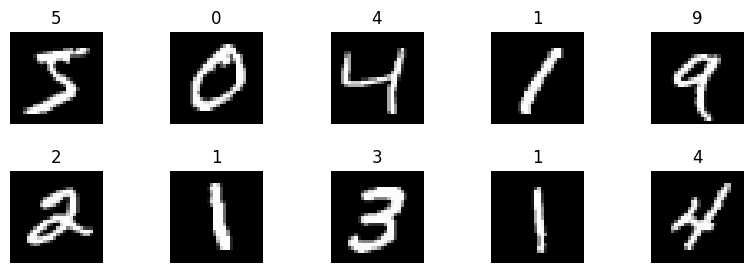

In [7]:
display_mnist_images(train_images[:10], train_labels[:10], rows=2, cols=5)

# Preprocess for federated learning

As we will demonstrate for federated learning, here we will split the datasets to simulate that each split will be trained on different clients.

<Axes: xlabel='0'>

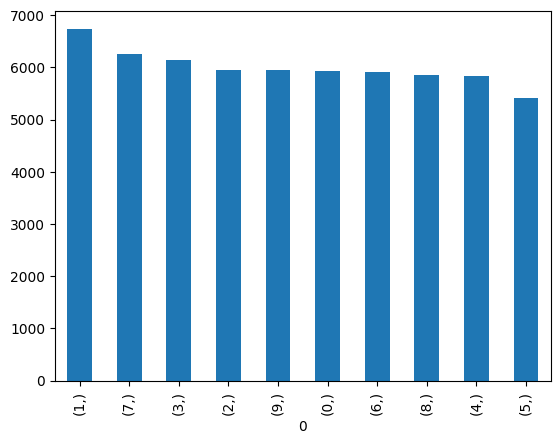

In [15]:
pd.DataFrame(train_labels).value_counts().plot(kind="bar")

In [6]:
classes = np.unique(train_labels)
clients = 7
datasets = {}
for _class in classes[:]:
    indexes = np.squeeze(np.array(np.where(train_labels == _class)))
    splits = len(indexes) // 7
    start = 0
    for client in range(clients):
        if client not in datasets:
            datasets[client] = {"image": [], "label": []}
        
        if client == clients - 1:
            imgs = train_images[indexes][start:] # at the last index take all the rest indexes
            lbls = train_labels[indexes][start:]
        else: 
            imgs = train_images[indexes][start:start + splits]
            lbls = train_labels[indexes][start:start + splits]
        
        datasets[client]["image"].extend(imgs)
        datasets[client]["label"].extend(lbls)
        
        start += splits
         

In [66]:
def process_data(data):
    image = np.array(data["image"]) / 255
    ds_slices = tf.data.Dataset.from_tensor_slices((image, np.array(data["label"])))
    return ds_slices

In [67]:
BATCH_SIZE = 32

datasets_clients = [
    process_data(datasets[x]).shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache() for x in datasets.keys()
]
testing_set = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Build the model

In [68]:
def create_model():
    inputs = tf.keras.layers.Input(shape=(28, 28))
    x = tf.keras.layers.Conv1D(256, 3, activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Conv1D(256, 3, activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Conv1D(512, 3, activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    outputs = tf.keras.layers.Dense(len(classes), activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])
    
    return model
    

In [104]:
master_model = create_model() # global modal
models = [create_model() for x in range(clients)] # client model

In [74]:
models[0].summary() # client 0

Model: "model_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_69 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 conv1d_202 (Conv1D)         (None, 26, 512)           43520     
                                                                 
 max_pooling1d_200 (MaxPooli  (None, 13, 512)          0         
 ng1D)                                                           
                                                                 
 global_average_pooling1d_55  (None, 512)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_62 (Dropout)        (None, 512)               0         
                                                                 
 dense_124 (Dense)           (None, 512)               262

# Callbacks

In [75]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, start_from_epoch=0)

# Train the model

In [76]:
history = []
EPOCHS = 100
for t in range(clients):  
    
    print(f"--------------------------------------- train client {t}")
    
    history.append(models[t].fit(
        datasets_clients[t], 
        epochs=EPOCHS,
        validation_data=testing_set,
        validation_steps=len(testing_set) * .2,
        callbacks=[early_stopping]
    ))
    models[t].save_weights(f"model.weigths.{t}.h5")
    
    print(f"---------------------------------------- Done train client {t}")

--------------------------------------- train client 0
Epoch 1/100
268/268 [==============================] - 3s 7ms/step - loss: 1.4983 - accuracy: 0.4834 - val_loss: 88.5306 - val_accuracy: 0.6806
Epoch 2/100
268/268 [==============================] - 2s 7ms/step - loss: 0.8056 - accuracy: 0.7379 - val_loss: 68.9298 - val_accuracy: 0.7832
Epoch 3/100
268/268 [==============================] - 2s 7ms/step - loss: 0.5976 - accuracy: 0.8107 - val_loss: 60.5912 - val_accuracy: 0.8239
Epoch 4/100
268/268 [==============================] - 2s 7ms/step - loss: 0.4844 - accuracy: 0.8462 - val_loss: 74.6780 - val_accuracy: 0.8026
Epoch 5/100
268/268 [==============================] - 2s 7ms/step - loss: 0.4148 - accuracy: 0.8704 - val_loss: 81.8421 - val_accuracy: 0.8080
Epoch 6/100
268/268 [==============================] - 2s 7ms/step - loss: 0.3711 - accuracy: 0.8801 - val_loss: 106.4225 - val_accuracy: 0.7808
Epoch 7/100
268/268 [==============================] - 2s 7ms/step - loss: 0.331

2023-05-16 15:06:29.773281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [8567,28,28]
	 [[{{node Placeholder/_0}}]]
2023-05-16 15:06:29.773728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [8567,28,28]
	 [[{{node Placeholder/_0}}]]


268/268 [==============================] - 3s 7ms/step - loss: 1.5530 - accuracy: 0.4654 - val_loss: 115.1699 - val_accuracy: 0.6181
Epoch 2/100
268/268 [==============================] - 2s 7ms/step - loss: 0.8601 - accuracy: 0.7266 - val_loss: 73.4389 - val_accuracy: 0.7708
Epoch 3/100
268/268 [==============================] - 2s 7ms/step - loss: 0.6235 - accuracy: 0.8038 - val_loss: 101.7985 - val_accuracy: 0.7391
Epoch 4/100
268/268 [==============================] - 2s 7ms/step - loss: 0.5059 - accuracy: 0.8427 - val_loss: 102.1774 - val_accuracy: 0.7614
Epoch 5/100
268/268 [==============================] - 2s 7ms/step - loss: 0.4478 - accuracy: 0.8618 - val_loss: 86.0505 - val_accuracy: 0.7961
Epoch 6/100
268/268 [==============================] - 2s 7ms/step - loss: 0.4004 - accuracy: 0.8727 - val_loss: 88.5702 - val_accuracy: 0.8001
---------------------------------------- Done train client 1
--------------------------------------- train client 2
Epoch 1/100


2023-05-16 15:06:42.023063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [8567,28,28]
	 [[{{node Placeholder/_0}}]]
2023-05-16 15:06:42.023485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [8567]
	 [[{{node Placeholder/_1}}]]


268/268 [==============================] - 3s 7ms/step - loss: 1.4953 - accuracy: 0.4858 - val_loss: 85.3996 - val_accuracy: 0.6910
Epoch 2/100
268/268 [==============================] - 2s 7ms/step - loss: 0.8190 - accuracy: 0.7348 - val_loss: 81.2133 - val_accuracy: 0.7937
Epoch 3/100
268/268 [==============================] - 2s 7ms/step - loss: 0.6041 - accuracy: 0.8080 - val_loss: 73.1754 - val_accuracy: 0.8170
Epoch 4/100
268/268 [==============================] - 2s 7ms/step - loss: 0.4867 - accuracy: 0.8462 - val_loss: 78.2630 - val_accuracy: 0.8274
Epoch 5/100
268/268 [==============================] - 2s 7ms/step - loss: 0.4228 - accuracy: 0.8649 - val_loss: 91.8191 - val_accuracy: 0.8085
Epoch 6/100
268/268 [==============================] - 2s 7ms/step - loss: 0.3596 - accuracy: 0.8828 - val_loss: 108.8104 - val_accuracy: 0.7966
Epoch 7/100
268/268 [==============================] - 2s 7ms/step - loss: 0.3396 - accuracy: 0.8921 - val_loss: 119.2924 - val_accuracy: 0.7812
--

2023-05-16 15:06:56.211713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [8567]
	 [[{{node Placeholder/_1}}]]
2023-05-16 15:06:56.212143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [8567]
	 [[{{node Placeholder/_1}}]]


268/268 [==============================] - 3s 7ms/step - loss: 1.4756 - accuracy: 0.4983 - val_loss: 95.6941 - val_accuracy: 0.6696
Epoch 2/100
268/268 [==============================] - 2s 7ms/step - loss: 0.8403 - accuracy: 0.7235 - val_loss: 94.2474 - val_accuracy: 0.7292
Epoch 3/100
268/268 [==============================] - 2s 7ms/step - loss: 0.6158 - accuracy: 0.8016 - val_loss: 96.1162 - val_accuracy: 0.7594
Epoch 4/100
268/268 [==============================] - 2s 7ms/step - loss: 0.4973 - accuracy: 0.8427 - val_loss: 94.0229 - val_accuracy: 0.7812
Epoch 5/100
268/268 [==============================] - 2s 7ms/step - loss: 0.4213 - accuracy: 0.8638 - val_loss: 100.3336 - val_accuracy: 0.7753
Epoch 6/100
268/268 [==============================] - 2s 7ms/step - loss: 0.3741 - accuracy: 0.8811 - val_loss: 116.6844 - val_accuracy: 0.7654
Epoch 7/100
268/268 [==============================] - 2s 7ms/step - loss: 0.3336 - accuracy: 0.8941 - val_loss: 150.0173 - val_accuracy: 0.7282
E

2023-05-16 15:07:12.325619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [8567]
	 [[{{node Placeholder/_1}}]]
2023-05-16 15:07:12.326090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [8567,28,28]
	 [[{{node Placeholder/_0}}]]


268/268 [==============================] - 3s 8ms/step - loss: 1.5160 - accuracy: 0.4832 - val_loss: 74.4221 - val_accuracy: 0.7123
Epoch 2/100
268/268 [==============================] - 2s 7ms/step - loss: 0.8253 - accuracy: 0.7320 - val_loss: 60.3216 - val_accuracy: 0.7991
Epoch 3/100
268/268 [==============================] - 2s 7ms/step - loss: 0.5940 - accuracy: 0.8095 - val_loss: 59.6701 - val_accuracy: 0.8289
Epoch 4/100
268/268 [==============================] - 2s 7ms/step - loss: 0.4888 - accuracy: 0.8458 - val_loss: 58.5984 - val_accuracy: 0.8423
Epoch 5/100
268/268 [==============================] - 2s 7ms/step - loss: 0.4202 - accuracy: 0.8667 - val_loss: 81.0495 - val_accuracy: 0.8031
Epoch 6/100
268/268 [==============================] - 2s 7ms/step - loss: 0.3748 - accuracy: 0.8812 - val_loss: 71.3376 - val_accuracy: 0.8333
Epoch 7/100
268/268 [==============================] - 2s 7ms/step - loss: 0.3385 - accuracy: 0.8930 - val_loss: 92.3586 - val_accuracy: 0.8100
Epoc

2023-05-16 15:07:28.675316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [8567]
	 [[{{node Placeholder/_1}}]]
2023-05-16 15:07:28.675753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [8567]
	 [[{{node Placeholder/_1}}]]


268/268 [==============================] - 3s 7ms/step - loss: 1.5202 - accuracy: 0.4818 - val_loss: 89.0475 - val_accuracy: 0.6562
Epoch 2/100
268/268 [==============================] - 2s 7ms/step - loss: 0.8352 - accuracy: 0.7308 - val_loss: 89.9067 - val_accuracy: 0.7237
Epoch 3/100
268/268 [==============================] - 2s 7ms/step - loss: 0.6126 - accuracy: 0.8042 - val_loss: 90.3829 - val_accuracy: 0.7510
Epoch 4/100
268/268 [==============================] - 2s 7ms/step - loss: 0.4950 - accuracy: 0.8413 - val_loss: 103.5763 - val_accuracy: 0.7480
Epoch 5/100
268/268 [==============================] - 2s 7ms/step - loss: 0.4282 - accuracy: 0.8639 - val_loss: 95.1687 - val_accuracy: 0.7758
---------------------------------------- Done train client 5
--------------------------------------- train client 6
Epoch 1/100


2023-05-16 15:07:39.146969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [8598,28,28]
	 [[{{node Placeholder/_0}}]]
2023-05-16 15:07:39.147353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [8598,28,28]
	 [[{{node Placeholder/_0}}]]


269/269 [==============================] - 3s 7ms/step - loss: 1.4422 - accuracy: 0.5062 - val_loss: 121.1446 - val_accuracy: 0.6369
Epoch 2/100
269/269 [==============================] - 2s 7ms/step - loss: 0.7617 - accuracy: 0.7546 - val_loss: 101.0657 - val_accuracy: 0.7465
Epoch 3/100
269/269 [==============================] - 2s 7ms/step - loss: 0.5571 - accuracy: 0.8224 - val_loss: 79.8376 - val_accuracy: 0.8001
Epoch 4/100
269/269 [==============================] - 2s 7ms/step - loss: 0.4510 - accuracy: 0.8573 - val_loss: 84.1968 - val_accuracy: 0.8135
Epoch 5/100
269/269 [==============================] - 2s 7ms/step - loss: 0.3971 - accuracy: 0.8757 - val_loss: 87.2168 - val_accuracy: 0.8155
Epoch 6/100
269/269 [==============================] - 2s 7ms/step - loss: 0.3445 - accuracy: 0.8937 - val_loss: 92.9850 - val_accuracy: 0.8249
Epoch 7/100
269/269 [==============================] - 2s 7ms/step - loss: 0.3181 - accuracy: 0.9002 - val_loss: 85.7250 - val_accuracy: 0.8313
--

# Test the accuracy of each client

In [79]:
!ls *.h5

model.weigths.0.h5  model.weigths.2.h5	model.weigths.4.h5  model.weigths.6.h5
model.weigths.1.h5  model.weigths.3.h5	model.weigths.5.h5


In [89]:
models_client_test = [create_model() for x in range(clients)]

In [105]:
for x in range(clients):
    models_client_test[x].load_weights(f"model.weigths.{x}.h5")

In [92]:
for x in range(clients 
    
    # make a prediction
    print(f"-------------------- Testing accuracy of client {x}")
    models_client_test[x].evaluate(testing_set)
    
    print("\n")

-------------------- Testing accuracy of client 0
313/313 [==============================] - 1s 4ms/step - loss: 82.6195 - accuracy: 0.8277


-------------------- Testing accuracy of client 1
313/313 [==============================] - 1s 4ms/step - loss: 72.1552 - accuracy: 0.8343


-------------------- Testing accuracy of client 2
313/313 [==============================] - 1s 4ms/step - loss: 107.2626 - accuracy: 0.7999


-------------------- Testing accuracy of client 3
313/313 [==============================] - 1s 4ms/step - loss: 160.8250 - accuracy: 0.7146


-------------------- Testing accuracy of client 4
313/313 [==============================] - 1s 4ms/step - loss: 74.9361 - accuracy: 0.8587


-------------------- Testing accuracy of client 5
313/313 [==============================] - 1s 4ms/step - loss: 84.9470 - accuracy: 0.8065


-------------------- Testing accuracy of client 6
313/313 [==============================] - 1s 4ms/step - loss: 73.4298 - accuracy: 0.8593




# Aggregate all the weights to the global model

In [113]:
# List of client weights proportions (e.g., dataset sizes or importance) 
# because we train each of our client model with relatively the same amount of datasets so i'll set the weight proportion to all the same
client_proportions = [(x + 1) / clients for x in range(clients)]

aggregated_weights = np.average(
    [x.get_weights() for x in models_client_test], 
    axis=0, weights=client_proportions)

# Set the aggregate weigths from each client to the global model

In [114]:
master_model.set_weights(aggregated_weights)

# We can make a prediction with the aggregated weights

In [115]:
master_model.evaluate(testing_set)

313/313 [==============================] - 1s 4ms/step - loss: 13.7522 - accuracy: 0.2337


[13.752226829528809, 0.2337000072002411]